In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import metrics 
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.utils import resample
#from sklearn.compose import ColumnTransformer
#from imblearn.pipeline import Pipeline
#from sklearn.feature_extraction import DictVectorizer
#from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier

In [3]:
Data = pd.read_csv('water_data-clean.csv')
Data_test = pd.read_csv('water_data_clean_test.csv')

In [48]:
Data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   funder             13981 non-null  object 
 1   installer          14850 non-null  object 
 2   region             14850 non-null  object 
 3   public_meeting     14850 non-null  bool   
 4   scheme_management  14850 non-null  object 
 5   permit             14850 non-null  bool   
 6   construction_year  14850 non-null  int64  
 7   extraction_type    14850 non-null  object 
 8   management         14850 non-null  object 
 9   payment            14850 non-null  object 
 10  water_quality      14850 non-null  object 
 11  quality_group      14850 non-null  object 
 12  quantity           14850 non-null  object 
 13  source_class       14850 non-null  object 
 14  waterpoint_type    14850 non-null  object 
 15  longitude_im       14850 non-null  float64
 16  latitude_im        148

In [5]:
Data.head(1)

,funder,installer,basin,subvillage,region,lga,ward,public_meeting,scheme_management,permit,...,quantity,source_class,waterpoint_type,status_group,longitude_im,latitude_im,district_code_im,gps_height_im,population_im,daysago
0,other,other,Lake Nyasa,Mnyusi B,Iringa,Ludewa,Mundindi,True,VWC,False,...,enough,groundwater,communal standpipe,functional,34.938093,-9.856322,5.0,1390.0,109.0,3362


In [6]:
#droping correlated  geografical featues leaving only longitude and latitude
Data_drop = Data.drop(['subvillage','ward','lga','basin'],axis=1,inplace=True)

Data_drop_test = Data_test.drop(['subvillage','ward','lga','basin'],axis=1,inplace=True)

## X and y 

In [7]:
X_train = Data.drop(["status_group"]  ,axis=1)
y_train = Data["status_group"]
X_train.shape

(59400, 21)

In [8]:
water_num = X_train.loc[:,((X_train.dtypes != np.object)&(X_train.dtypes != np.bool))]
water_obj = X_train.loc[:,((X_train.dtypes == np.object)|(X_train.dtypes == np.bool))]

water_num_test = Data_test.loc[:,((Data_test.dtypes != np.object)&(Data_test.dtypes != np.bool))] 
water_obj_test = Data_test.loc[:,((Data_test.dtypes == np.object)|(Data_test.dtypes == np.bool))]

cat_att= list(water_obj)
num_att= list(water_num)
# num_att=['construction_year',
#  'district_code_im',
#  'gps_height_im',
#  'population_im',
#  'daysago']#excluding lon and lat from scaler


## get dummies

In [9]:
dummies = pd.get_dummies(water_obj)
dummies_test = pd.get_dummies(water_obj_test)

In [10]:
X_train_dummie = pd.concat([water_num, dummies], axis=1)
X_test_dummie =pd.concat([water_num_test, dummies_test], axis=1)
X_test_dummie.shape

(14850, 143)

## Dummy Classifier

In [12]:
dclf = DummyClassifier(strategy = 'most_frequent', random_state = 0) 
dclf.fit(X_train, y_train) 
score = dclf.score(X_test, y_test) 
score

0.5392592592592592

In [13]:
y_test.value_counts()

functional                 8008
non functional             5780
functional needs repair    1062
Name: status_group, dtype: int64

## KNN with only lat and long

In [14]:
y_train.shape

(44550,)

In [15]:
X_train_lat_lon = X_train[['latitude_im','longitude_im']]
X_test_lat_lon = X_test[['latitude_im','longitude_im']]

In [16]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_lat_lon, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [67]:
#predict the training set
y_pred_train_lon = knn.predict(X_train_lat_lon)
y_pred_test_lon = knn.predict(X_test_lat_lon)

print("Training F1 Score:",metrics.f1_score(y_train, y_pred_train_lon,average='weighted'))
print("Training Acuracy Score:",metrics.accuracy_score(y_train, y_pred_train_lon))

print("Testing F1 Score:",metrics.f1_score(y_test, y_pred_test_lon,average='weighted'))
print("Testing Acuracy Score:",metrics.accuracy_score(y_test, y_pred_test_lon))

Training F1 Score: 0.7094411253714862
Training Acuracy Score: 0.723591470258137
Testing F1 Score: 0.6619313116990926
Testing Acuracy Score: 0.6773737373737374


In [69]:
confusion_matrix(y_test,y_pred_test_lon)

array([[6629,  112, 1267],
       [ 625,  194,  243],
       [2452,   92, 3236]])

## Randon Forest

### pipeline for onehot encode

In [ ]:
num_pipe = Pipeline([('std_scaler', StandardScaler())])

In [ ]:
full_pipeline = ColumnTransformer([('num', num_pipe, num_att),
                                  ('cat',OneHotEncoder(), cat_att)])

In [ ]:
X_train_pipe = full_pipeline.fit_transform(X_train)

In [ ]:
train_x_encoded.columns = full_pipeline.get_feature_names(X_train)

### Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_train_dummie, y_train, random_state=3)

### fit and predict 

In [ ]:
forest = RandomForestClassifier()
forest.fit(X_train ,y_train)

In [ ]:
#predict the training set
y_pred_train = forest.predict(X_train)
y_pred_test = forest.predict(X_test)

print("Training F1 Score:",metrics.f1_score(y_train, y_pred_train,average='weighted'))
print("Training Acuracy Score:",metrics.accuracy_score(y_train, y_pred_train))

print("Testing F1 Score:",metrics.f1_score(y_test, y_pred_test,average='weighted'))
print("Testing Acuracy Score:",metrics.accuracy_score(y_test, y_pred_test))

In [ ]:
confusion_matrix(y_test, y_pred_test)

In [ ]:
feature_importances = pd.DataFrame(forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [ ]:
feature_importances.head(15)

## Grid Search

In [95]:
rforest = RandomForestClassifier(n_jobs=-1,class_weight='balanced')

In [96]:
param_grid = {'n_estimators':[250,500,650],
             'max_depth':[100,150,200],
             'min_samples_split':[4,5,6],
              'criterion':['gini', 'entropy']
              }

In [97]:
gscv = GridSearchCV(estimator=rforest,
                   param_grid=param_grid,
                   scoring='f1_weighted',
                   cv=3,
                   n_jobs=-1,
                   verbose=10)

In [98]:
gs = gscv.fit(X_train,y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 66.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 250.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 254.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 258.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 262.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 267.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 272.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 278.1min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elap

In [99]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=150, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=650,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [100]:
gs.best_score_

0.7915280131438118

In [101]:
gs.best_params_

{'criterion': 'gini',
 'max_depth': 150,
 'min_samples_split': 4,
 'n_estimators': 650}

In [102]:
#predict the training set
y_pred_train = gs.best_estimator_.predict(X_train)
y_pred_test = gs.best_estimator_.predict(X_test)
y_pred_test_competition = gs.best_estimator_.predict(X_test_dummie)

print("Training F1 Score:",metrics.f1_score(y_train, y_pred_train,average='weighted'))
print("Training Acuracy Score:",metrics.accuracy_score(y_train, y_pred_train))

print("Testing F1 Score:",metrics.f1_score(y_test, y_pred_test,average='weighted'))
print("Testing Acuracy Score:",metrics.accuracy_score(y_test, y_pred_test))

Training F1 Score: 0.9771343458607524
Training Acuracy Score: 0.9769472502805836
Testing F1 Score: 0.8101954330860917
Testing Acuracy Score: 0.8111111111111111


In [103]:
confusion_matrix(y_test, y_pred_test)

array([[6930,  383,  695],
       [ 444,  478,  140],
       [ 995,  148, 4637]])

In [104]:
feature_importances = pd.DataFrame(gs.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.to_csv('feature_importances.csv', sep=',')
best_features = feature_importances.head(15)
best_features

,importance
longitude_im,0.100007
latitude_im,0.098107
gps_height_im,0.088853
population_im,0.075168
daysago,0.072630
quantity_dry,0.053704
construction_year,0.046094
district_code_im,0.028376
quantity_enough,0.020165
extraction_type_other,0.019144


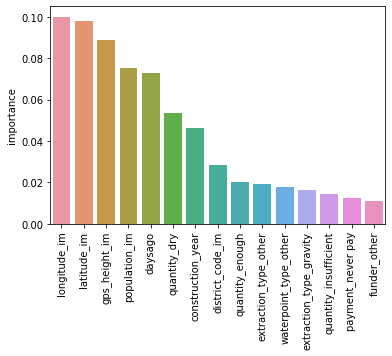

In [105]:
chart = sns.barplot(x=best_features.index.values, y='importance', data=best_features)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

# make submision file

In [106]:
test_submision = pd.read_csv('water_data_clean_test_2.csv')

In [107]:
df = pd.DataFrame(data=y_pred_test_competition.flatten())

In [108]:
result = pd.concat([test_submision, df], axis=1, sort=False)

In [109]:
result =result[['id',0]]

In [110]:
result.columns = ['id', 'status_group']

In [111]:
result.to_csv('result_submision.csv', index=False)